# Intent Benchmark 

This document contains visuals for a intent benchmark. The code that generates the data can be found in `benchmark.py`. This notebook will mainly share a story on how to interpret/run numbers.

In [3]:
import altair as alt 
import hiplot as hip 
import pandas as pd

df = pd.read_json('data/n-ft-use-train-experiment.jsonl', lines=True)

## Benchmark Results 

Let's discuss the results of a benchmark. We will compare FastText embeddings with embeddings for the Universal Sentence Encoder. We're interested in doing a benchmark for intent classification for chatbots so we'll use a dataset for that purpose.

In [4]:
pd.read_csv("data/outofscope-intent-classification-dataset.csv").sample(5)

,text,label
5335,can you tell me how to make a vacation request,pto_request
5525,tell me something neat about slinkies,fun_fact
5807,when will you mail me a replacement card,replacement_card_duration
22990,i'd like to find some curtains that look good ...,oos
2471,are you a pet owner and what kind,do_you_have_pets


The suggestion, now, is that we may be able to recommend using FastText vs. USE to external stakeholders. 

<img src="pipeline.png" width=800>

This dataset has 150 intents with 150 examples each. We split up a train/test and we run `benchmark.py`. 

This gives us the following results:

In [5]:
(df
 .loc[lambda d: d['train_size'] == 9500]
 .loc[lambda d: d['emb'].isin(['ft', 'use'])]
 [['emb', 'accuracy_test', 'pred_time']])

,emb,accuracy_test,pred_time
49,ft,0.91850,0.384681
68,use,0.92475,4.291162


### Can we declare a win?

Let's take a principled approach. We have 4000 test cases.

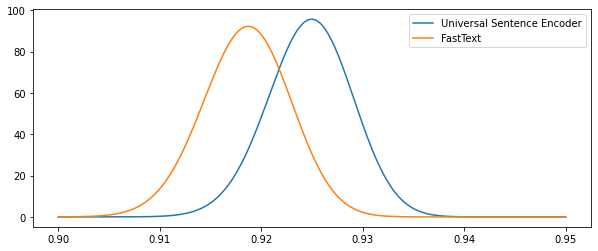

In [6]:
import numpy as np
from scipy.stats import beta
import matplotlib.pylab as plt

p_use, p_ft = 0.92475, 0.91850

x = np.linspace(0.90, 0.95, 1000)
pdf_use = beta(p_use*4000, (1-p_use)*4000).pdf(x)
pdf_ft = beta(p_ft*4000, (1-p_ft)*4000).pdf(x)

plt.figure(figsize=(10, 4))
plt.plot(x, pdf_use, label="Universal Sentence Encoder")
plt.plot(x, pdf_ft, label="FastText")
plt.legend();

In [7]:
samples_use = beta(p_use*4000, (1-p_use)*4000).rvs(1000)
samples_ft = beta(p_ft*4000, (1-p_ft)*4000).rvs(1000)
(samples_use > samples_ft).mean()

0.862

Usually folks want 0.95 certainty or something. If that includes you ... our "better stat" suddenly isn't that convincing anymore.

But there's something bigger lying under the grass.

## Results 

Protips for doing benchmarks. 

1. Run the beta test. We just did this. 
2. Add in a super simple benchmark. 
3. Check the effect of training data size. 

My original benchmark actually did this. I also added a model that uses *no* embeddings. 

The results are summarised below: 

In [8]:
(alt.Chart(df.loc[lambda d: d['dataset'] == 'scope'])
      .mark_line()
      .encode(x='train_size', y='accuracy_test', color=alt.Color('emb'))
      .properties(width=800, height=250, title=f"test performance")
      .interactive())

alt.Chart(...)

But even this ... isn't the most broken part of the benchmark. Let's sample our original dataset again.

In [9]:
pd.read_csv("data/outofscope-intent-classification-dataset.csv").sample(25)

,text,label
17605,play some music for me,play_music
5803,is my card made immedietly after reporting stolen,replacement_card_duration
12600,where can i see the routing number for bmo,routing
2994,is there a fee if i use my card in france,international_fees
14846,i'm thinking someone may have used my card in ...,report_fraud
11756,dial someone's phone number,make_call
17266,write a text to alice,text
2926,what could cause a hold on my savings account,account_blocked
8857,i am needing for you to say that again,repeat
11140,roll a dice and give me a number from 1 to 6,roll_dice


Does this dataset ... resemble an actual assistant out there? Or does it resemble a weird mix of just all of them?